# Introduction
- This project builds a cleaned, feature‑rich ATP singles match dataset (1992–2024), enriches it with ELO ratings, and performs EDA and modeling.

### Key visuals: 
- 2nd‑serve impact
- top players by surface
- yearly top ELO
- top‑5 ELO trajectories.
- age vs performance

### ML goal: 
 - Predict match winners (balance labels, clean outliers, train & evaluate classifiers).

# Changes since the proposal
We swapped the stock project for ATP match analysis after chatting with the professor. Now we’re building a cleaned dataset (1992–2024) with ELOs, doing quick EDA (2nd‑serve impact, surface specialists, yearly top ELO, top‑5 ELO trends) and training models to predict match winners.

# Dataset Construction:
We build final_data by taking each match (winner vs loser) and converting raw match fields into player‑pair difference features (PLAYER_1 − PLAYER_2).
This yields direct comparative predictors for modeling match outcomes.
## Key Derived Columns:
- *Ranking/Points:* ATP_POINT_DIFF = winner_rank_points - loser_rank_points, ATP_RANK_DIFF = winner_rank - loser_rank.
- *Demographics:* AGE_DIFF, HEIGHT_DIFF.
- *Match Context:* BEST_OF, DRAW_SIZE.
- *Head‑to‑Head:* H2H_DIFF and H2H_SURFACE_DIFF computed from prior matches (overall and surface‑specific).
- *Rolling Performance:* For k ∈ {3,5,10,20,50,100,200,300,2000}, percent‑based serve/defense differences (e.g., P_ACE_LAST_k_DIFF, P_1ST_WON_LAST_k_DIFF) are computed with per‑player rolling deques and sampled before each match.
- *Recent Form:* WIN_LAST_k_DIFF = recent win‑rate difference using rolling windows (k ∈ {3,5,10,20,50,100,200,300,2000}).
- *ELO:* Merged atp_elo_ratings.csv (name normalization) to compute ELO_DIFF and SURF_ELO_DIFF (surface‑specific ELO when available).

## Import packages here

In [1]:
import pandas as pd

## Combine data of all years

In [2]:
all_data = pd.DataFrame()
for year in range(1992, 2025):
    file = "./Data/SingleMatches/atp_matches_"+str(year)+'.csv'

    year_data = pd.read_csv(file)

    all_data = pd.concat([all_data, year_data], axis = 0)

all_data

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1992-339,Adelaide,Hard,32,A,19911230,1,101964,1.0,NaN,...,34.0,23.0,6.0,9.0,0.0,3.0,16.0,NaN,80.0,NaN
1,1992-339,Adelaide,Hard,32,A,19911230,2,101924,NaN,NaN,...,65.0,39.0,9.0,10.0,8.0,12.0,65.0,NaN,63.0,NaN
2,1992-339,Adelaide,Hard,32,A,19911230,3,101195,NaN,NaN,...,68.0,45.0,22.0,16.0,8.0,12.0,62.0,NaN,730.0,NaN
3,1992-339,Adelaide,Hard,32,A,19911230,4,101820,NaN,NaN,...,49.0,34.0,16.0,14.0,1.0,4.0,60.0,NaN,42.0,NaN
4,1992-339,Adelaide,Hard,32,A,19911230,5,100870,NaN,NaN,...,95.0,65.0,15.0,18.0,5.0,7.0,68.0,NaN,32.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,5,212051,NaN,NaN,...,30.0,17.0,7.0,6.0,8.0,14.0,1109.0,8.0,740.0,34.0
3072,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,1,122533,NaN,NaN,...,41.0,25.0,6.0,9.0,1.0,4.0,554.0,67.0,748.0,32.0
3073,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,2,144748,NaN,NaN,...,51.0,25.0,7.0,11.0,5.0,12.0,416.0,109.0,NaN,NaN
3074,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,20240202,4,122533,NaN,NaN,...,51.0,32.0,17.0,14.0,5.0,9.0,554.0,67.0,416.0,109.0


In [3]:
all_data.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

## Filter out missing data

In [4]:
filtered_data = all_data.dropna(subset=[
        'winner_id', 'winner_name', 'loser_id', 'loser_name', 'winner_ht', 'winner_age', 'loser_ht', 'loser_age',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
        'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 
        'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points',
        'loser_rank', 'loser_rank_points', 'surface'])

filtered_data = filtered_data.reset_index(drop=True)            #starts index back from zero

filtered_data

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1992-301,Auckland,Hard,32,A,19920106,1,101797,NaN,NaN,...,50.0,40.0,24.0,12.0,4.0,4.0,110.0,333.0,8.0,1599.0
1,1992-301,Auckland,Hard,32,A,19920106,2,101205,NaN,NaN,...,58.0,28.0,10.0,9.0,5.0,8.0,78.0,462.0,101.0,378.0
2,1992-301,Auckland,Hard,32,A,19920106,3,101368,NaN,NaN,...,28.0,19.0,11.0,9.0,4.0,8.0,82.0,436.0,1059.0,3.0
3,1992-301,Auckland,Hard,32,A,19920106,4,100772,NaN,WC,...,46.0,31.0,16.0,12.0,3.0,6.0,171.0,201.0,52.0,607.0
4,1992-301,Auckland,Hard,32,A,19920106,5,101532,4.0,NaN,...,57.0,39.0,21.0,14.0,9.0,12.0,30.0,837.0,99.0,383.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92328,2024-M-DC-2024-WG2-PO-TOG-INA-01,Davis Cup WG2 PO: TOG vs INA,Hard,4,D,20240203,4,207134,NaN,NaN,...,35.0,19.0,5.0,8.0,5.0,9.0,569.0,64.0,819.0,24.0
92329,2024-M-DC-2024-WG2-PO-TUN-CRC-01,Davis Cup WG2 PO: TUN vs CRC,Hard,4,D,20240202,1,121411,NaN,NaN,...,30.0,17.0,9.0,8.0,2.0,5.0,279.0,205.0,900.0,18.0
92330,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,1,208364,NaN,NaN,...,52.0,24.0,18.0,12.0,8.0,16.0,616.0,55.0,740.0,34.0
92331,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,4,105430,NaN,NaN,...,66.0,33.0,6.0,8.0,6.0,11.0,136.0,489.0,616.0,55.0


### Calculating Final Data and Features

In [5]:
final_data = pd.DataFrame()
final_data['WINNER_ID'] = filtered_data['winner_id']
final_data['WINNER_NAME'] = filtered_data['winner_name']
final_data['LOSER_ID'] = filtered_data['loser_id']
final_data['LOSER_NAME'] = filtered_data['loser_name']
final_data['ATP_POINT_DIFF'] = filtered_data['winner_rank_points'] - filtered_data['loser_rank_points']
final_data['ATP_RANK_DIFF'] = filtered_data['winner_rank'] - filtered_data['loser_rank']
final_data['AGE_DIFF'] = filtered_data['winner_age'] - filtered_data['loser_age']
final_data['HEIGHT_DIFF'] = filtered_data['winner_ht'] - filtered_data['loser_ht']
final_data['BEST_OF'] = filtered_data['best_of']
final_data['DRAW_SIZE'] = filtered_data['draw_size']

final_data

,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE
0,101797,Jacco Eltingh,101120,Karel Novacek,-1266.0,102.0,-5.4,-2.0,3,32
1,101205,Grant Connell,101767,Lars Jonsson,84.0,-23.0,4.6,-3.0,3,32
2,101368,Christian Miniussi,102536,James Greenhalgh,433.0,-977.0,7.7,2.0,3,32
3,100772,Kelly Evernden,101746,Renzo Furlan,-406.0,119.0,8.6,0.0,3,32
4,101532,Francisco Clavet,101119,Marian Vajda,454.0,-69.0,-3.5,10.0,3,32
...,...,...,...,...,...,...,...,...,...,...
92328,207134,Fitriadi M Rifqi,133933,Thomas Yaka Kofi Setodji,40.0,-250.0,-3.2,-8.0,3,4
92329,121411,Moez Echargui,132374,Jesse Flores,187.0,-621.0,2.2,-10.0,3,4
92330,208364,Franco Roncadelli,209943,Ilya Snitari,21.0,-124.0,2.1,-3.0,3,4
92331,105430,Radu Albot,208364,Franco Roncadelli,434.0,-480.0,10.3,-10.0,3,4


### Head-to-Head Feature Calculation

Calculated two features:
- **H2H_DIFF:** Overall head-to-head win difference between the two players before the current match.  
- **H2H_SURFACE_DIFF:** Head-to-head win difference on the same surface.  

Both are computed by tracking previous match results for each player pair and updating after every match.


In [6]:
# Calculate H2H and H2H on that surface
from collections import defaultdict
from tqdm import tqdm

h2h_surface_dict = defaultdict(lambda: defaultdict(int))
h2h_dict = defaultdict(int)
total_h2h_surface = []
total_h2h = []

for idx, (w_id, l_id, surface) in enumerate(tqdm(zip(filtered_data['winner_id'],
                                                     filtered_data['loser_id'],
                                                     filtered_data['surface']),
                                                 total=len(filtered_data))):
    wins = h2h_dict[(w_id, l_id)]
    loses = h2h_dict[(l_id, w_id)]

    wins_surface = h2h_surface_dict[surface][(w_id, l_id)]
    loses_surface = h2h_surface_dict[surface][(l_id, w_id)]

    total_h2h.append(wins - loses)
    total_h2h_surface.append(wins_surface - loses_surface)

    h2h_dict[(w_id, l_id)] += 1
    h2h_surface_dict[surface][(w_id, l_id)] += 1

final_data["H2H_DIFF"] = total_h2h
final_data["H2H_SURFACE_DIFF"] = total_h2h_surface

final_data


ModuleNotFoundError: No module named 'tqdm'

###  Rolling Serve/Performance Feature Calculation

For each match and window size *k* ∈ {3,5,10,20,50,100,200,300,2000}, we compute PLAYER_1 − PLAYER_2 differences of recent averages for: %Aces, %Double Faults, %1st Serve In, %1st Serve Won, %2nd Serve Won, and %Break Points Saved.  
We iterate chronologically, use per-player deques (maxlen = k) to track last-k percentages, read pre-match means, then update with the current match stats.


In [ ]:
from collections import defaultdict, deque
import numpy as np


def smean(seq):
    """Safe mean -> 0.0 when empty."""
    return float(np.mean(seq)) if seq else 0.0

all_data_filtered = filtered_data.sort_values(
    ['tourney_date', 'match_num'], kind='mergesort'
).reset_index(drop=True)


for k in [3, 5, 10, 20, 50, 100, 200, 300, 2000]:
  
    last_k_matches = defaultdict(lambda: defaultdict(lambda: deque(maxlen=k)))

    
    p_ace_k      = []
    p_df_k       = []
    p_1stIn_k    = []
    p_1stWon_k   = []
    p_2ndWon_k   = []
    p_bpSaved_k  = []

   
    for row in all_data_filtered.itertuples(index=False):
        
        w_id, l_id = row.winner_id, row.loser_id

       
        w_ace,   l_ace   = row.w_ace,   row.l_ace
        w_df,    l_df    = row.w_df,    row.l_df
        w_svpt,  l_svpt  = row.w_svpt,  row.l_svpt
        w_1stIn, l_1stIn = row.w_1stIn, row.l_1stIn
        w_1stWon,l_1stWon= row.w_1stWon,row.l_1stWon
        w_2ndWon,l_2ndWon= row.w_2ndWon,row.l_2ndWon
        w_SvGms,l_SvGms  = row.w_SvGms, row.l_SvGms
        w_bpSaved,l_bpSaved = row.w_bpSaved, row.l_bpSaved
        w_bpFaced,l_bpFaced = row.w_bpFaced, row.l_bpFaced

        
        p_ace_k.append( smean(last_k_matches[w_id]["p_ace"]) - smean(last_k_matches[l_id]["p_ace"]))
        p_df_k.append( smean(last_k_matches[w_id]["p_df"]) - smean(last_k_matches[l_id]["p_df"]))
        p_1stIn_k.append( smean(last_k_matches[w_id]["p_1stIn"]) - smean(last_k_matches[l_id]["p_1stIn"]))
        p_1stWon_k.append( smean(last_k_matches[w_id]["p_1stWon"]) - smean(last_k_matches[l_id]["p_1stWon"]))
        p_2ndWon_k.append( smean(last_k_matches[w_id]["p_2ndWon"]) - smean(last_k_matches[l_id]["p_2ndWon"]))
        p_bpSaved_k.append( smean(last_k_matches[w_id]["p_bpSaved"]) - smean(last_k_matches[l_id]["p_bpSaved"]))

        
        # Winner percentages
        if w_svpt != 0:
            last_k_matches[w_id]["p_ace"].append(100.0 * (w_ace / w_svpt))
            last_k_matches[w_id]["p_df"].append(100.0 * (w_df / w_svpt))
            last_k_matches[w_id]["p_1stIn"].append(100.0 * (w_1stIn / w_svpt))
        if w_1stIn != 0:
            last_k_matches[w_id]["p_1stWon"].append(100.0 * (w_1stWon / w_1stIn))
        if (w_svpt - w_1stIn) != 0:
            last_k_matches[w_id]["p_2ndWon"].append(100.0 * (w_2ndWon / (w_svpt - w_1stIn)))
        if w_bpFaced != 0:
            last_k_matches[w_id]["p_bpSaved"].append(100.0 * (w_bpSaved / w_bpFaced))

        # Loser percentages
        if l_svpt != 0:
            last_k_matches[l_id]["p_ace"].append(100.0 * (l_ace / l_svpt))
            last_k_matches[l_id]["p_df"].append(100.0 * (l_df / l_svpt))
            last_k_matches[l_id]["p_1stIn"].append(100.0 * (l_1stIn / l_svpt))
        if l_1stIn != 0:
            last_k_matches[l_id]["p_1stWon"].append(100.0 * (l_1stWon / l_1stIn))
        if (l_svpt - l_1stIn) != 0:
            last_k_matches[l_id]["p_2ndWon"].append(100.0 * (l_2ndWon / (l_svpt - l_1stIn)))
        if l_bpFaced != 0:
            last_k_matches[l_id]["p_bpSaved"].append(100.0 * (l_bpSaved / l_bpFaced))

    final_data[f"P_ACE_LAST_{k}_DIFF"]      = p_ace_k
    final_data[f"P_DF_LAST_{k}_DIFF"]       = p_df_k
    final_data[f"P_1ST_IN_LAST_{k}_DIFF"]   = p_1stIn_k
    final_data[f"P_1ST_WON_LAST_{k}_DIFF"]  = p_1stWon_k
    final_data[f"P_2ND_WON_LAST_{k}_DIFF"]  = p_2ndWon_k
    final_data[f"P_BP_SAVED_LAST_{k}_DIFF"] = p_bpSaved_k


In [ ]:
final_data

,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE,...,P_1ST_IN_LAST_300_DIFF,P_1ST_WON_LAST_300_DIFF,P_2ND_WON_LAST_300_DIFF,P_BP_SAVED_LAST_300_DIFF,P_ACE_LAST_2000_DIFF,P_DF_LAST_2000_DIFF,P_1ST_IN_LAST_2000_DIFF,P_1ST_WON_LAST_2000_DIFF,P_2ND_WON_LAST_2000_DIFF,P_BP_SAVED_LAST_2000_DIFF
0,101797,Jacco Eltingh,101120,Karel Novacek,-1266.0,102.0,-5.4,-2.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,101205,Grant Connell,101767,Lars Jonsson,84.0,-23.0,4.6,-3.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,101368,Christian Miniussi,102536,James Greenhalgh,433.0,-977.0,7.7,2.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,100772,Kelly Evernden,101746,Renzo Furlan,-406.0,119.0,8.6,0.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,101532,Francisco Clavet,101119,Marian Vajda,454.0,-69.0,-3.5,10.0,3,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92328,207134,Fitriadi M Rifqi,133933,Thomas Yaka Kofi Setodji,40.0,-250.0,-3.2,-8.0,3,4,...,6.622831,-13.411429,0.291809,2.718619,-4.685967,-1.811381,6.622831,-13.411429,0.291809,2.718619
92329,121411,Moez Echargui,132374,Jesse Flores,187.0,-621.0,2.2,-10.0,3,4,...,1.269346,1.862017,2.029024,0.848561,-3.006825,0.054561,1.269346,1.862017,2.029024,0.848561
92330,208364,Franco Roncadelli,209943,Ilya Snitari,21.0,-124.0,2.1,-3.0,3,4,...,0.126691,-5.910131,-1.772576,5.050027,-1.635691,-0.493191,0.126691,-5.910131,-1.772576,5.050027
92331,105430,Radu Albot,208364,Franco Roncadelli,434.0,-480.0,10.3,-10.0,3,4,...,5.002503,0.485732,6.268410,-5.179438,1.322220,-1.550933,5.002503,0.485732,6.268410,-5.179438


### Recent Form (Win Rate) Feature Calculation

For each player, we tracked their win rate over the last *k* matches where *k* ∈ {3, 5, 10, 25, 50, 100}.  
Before every match, we computed the difference in recent win percentages between PLAYER_1 and PLAYER_2, then updated the rolling records (1 = win, 0 = loss).  
Finally, a `RESULT` column was added as 1 since each row represents the winner’s perspective.


In [ ]:
from collections import defaultdict, deque
import numpy as np

for k in [3, 5, 10, 25, 50, 100]:
    recent_results = defaultdict(lambda: deque(maxlen=k))
    win_last_k = []

    for row in filtered_data.itertuples(index=False):
        w_id, l_id = row.winner_id, row.loser_id

        # Past win % before current match
        w_winrate = np.mean(recent_results[w_id]) if recent_results[w_id] else 0
        l_winrate = np.mean(recent_results[l_id]) if recent_results[l_id] else 0
        win_last_k.append(w_winrate - l_winrate)

        # Update running results (1 = win, 0 = loss)
        recent_results[w_id].append(1)
        recent_results[l_id].append(0)

    final_data[f'WIN_LAST_{k}_DIFF'] = win_last_k
    
final_data['RESULT'] = 1  # winner always 1 since each row is from winner’s perspective



In [ ]:
final_data.columns

Index(['WINNER_ID', 'WINNER_NAME', 'LOSER_ID', 'LOSER_NAME', 'ATP_POINT_DIFF',
       'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE',
       'H2H_DIFF', 'H2H_SURFACE_DIFF', 'P_ACE_LAST_3_DIFF', 'P_DF_LAST_3_DIFF',
       'P_1ST_IN_LAST_3_DIFF', 'P_1ST_WON_LAST_3_DIFF',
       'P_2ND_WON_LAST_3_DIFF', 'P_BP_SAVED_LAST_3_DIFF', 'P_ACE_LAST_5_DIFF',
       'P_DF_LAST_5_DIFF', 'P_1ST_IN_LAST_5_DIFF', 'P_1ST_WON_LAST_5_DIFF',
       'P_2ND_WON_LAST_5_DIFF', 'P_BP_SAVED_LAST_5_DIFF', 'P_ACE_LAST_10_DIFF',
       'P_DF_LAST_10_DIFF', 'P_1ST_IN_LAST_10_DIFF', 'P_1ST_WON_LAST_10_DIFF',
       'P_2ND_WON_LAST_10_DIFF', 'P_BP_SAVED_LAST_10_DIFF',
       'P_ACE_LAST_20_DIFF', 'P_DF_LAST_20_DIFF', 'P_1ST_IN_LAST_20_DIFF',
       'P_1ST_WON_LAST_20_DIFF', 'P_2ND_WON_LAST_20_DIFF',
       'P_BP_SAVED_LAST_20_DIFF', 'P_ACE_LAST_50_DIFF', 'P_DF_LAST_50_DIFF',
       'P_1ST_IN_LAST_50_DIFF', 'P_1ST_WON_LAST_50_DIFF',
       'P_2ND_WON_LAST_50_DIFF', 'P_BP_SAVED_LAST_50_DIFF',
       

##  Feature Description 

###  Player Identifiers
| Column | Description |
|---------|--------------|
| **PLAYER_1** | ID of the first player (winner in original data or perspective player after balancing). |
| **PLAYER_2** | ID of the opponent (loser in original data or the other player in balanced version). |

---

###  Basic Match & Ranking Differences
| Column | Description |
|---------|--------------|
| **ATP_POINT_DIFF** | Difference in ATP ranking points between PLAYER_1 and PLAYER_2 *(PLAYER_1 − PLAYER_2)*. |
| **ATP_RANK_DIFF** | Difference in ATP ranking positions *(PLAYER_1 − PLAYER_2)* — lower means better rank. |
| **AGE_DIFF** | Difference in age between PLAYER_1 and PLAYER_2 (in years). |
| **HEIGHT_DIFF** | Height difference between PLAYER_1 and PLAYER_2 (in cm). |
| **BEST_OF** | Number of sets played in the match (e.g., 3 or 5). |
| **DRAW_SIZE** | Tournament draw size (e.g., 32, 64, 128 players). |

---

###  Head-to-Head Performance
| Column | Description |
|---------|--------------|
| **H2H_DIFF** | Overall win–loss record difference between PLAYER_1 and PLAYER_2 before this match. |
| **H2H_SURFACE_DIFF** | Win–loss difference between PLAYER_1 and PLAYER_2 *on the same surface* (Hard/Clay/Grass) before this match. |

---

###  Serve & Performance Statistics (Rolling Windows)
Each feature represents the **difference** in averages between PLAYER_1 and PLAYER_2 over the **last *k* matches**.

| Category | Example Columns | Description |
|-----------|------------------|--------------|
| **Aces** | `P_ACE_LAST_k_DIFF` | Difference in % of points won by aces in the last *k* matches. |
| **Double Faults** | `P_DF_LAST_k_DIFF` | Difference in % of double faults made in the last *k* matches. |
| **First Serve In** | `P_1ST_IN_LAST_k_DIFF` | Difference in % of first serves successfully landed in play. |
| **First Serve Won** | `P_1ST_WON_LAST_k_DIFF` | Difference in % of points won on first serve. |
| **Second Serve Won** | `P_2ND_WON_LAST_k_DIFF` | Difference in % of points won on second serve. |
| **Break Points Saved** | `P_BP_SAVED_LAST_k_DIFF` | Difference in % of break points saved (defensive success under pressure). |

Where *k ∈ {3, 5, 10, 20, 50, 100, 200, 300, 2000}* — representing the rolling window size.

---

### Form / Momentum Features
| Column | Description |
|---------|--------------|
| **WIN_LAST_3_DIFF** | Difference in win rate between PLAYER_1 and PLAYER_2 over their last 3 matches. |
| **WIN_LAST_5_DIFF** | Difference in win rate over last 5 matches. |
| **WIN_LAST_10_DIFF** | Difference in win rate over last 10 matches. |
| **WIN_LAST_25_DIFF** | Difference in win rate over last 25 matches. |
| **WIN_LAST_50_DIFF** | Difference in win rate over last 50 matches. |
| **WIN_LAST_100_DIFF** | Difference in win rate over last 100 matches. |

These features capture short-term and long-term momentum or player form.

---

###  Target Variable
| Column | Description |
|---------|--------------|
| **RESULT** | Match outcome label from PLAYER_1’s perspective — `1` if PLAYER_1 won, `0` if lost (after balancing). Always `1` in the original winner-only dataset. |

---



In [ ]:
final_data.head()

,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE,...,P_1ST_WON_LAST_2000_DIFF,P_2ND_WON_LAST_2000_DIFF,P_BP_SAVED_LAST_2000_DIFF,WIN_LAST_3_DIFF,WIN_LAST_5_DIFF,WIN_LAST_10_DIFF,WIN_LAST_25_DIFF,WIN_LAST_50_DIFF,WIN_LAST_100_DIFF,RESULT
0,101797,Jacco Eltingh,101120,Karel Novacek,-1266.0,102.0,-5.4,-2.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,101205,Grant Connell,101767,Lars Jonsson,84.0,-23.0,4.6,-3.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,101368,Christian Miniussi,102536,James Greenhalgh,433.0,-977.0,7.7,2.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100772,Kelly Evernden,101746,Renzo Furlan,-406.0,119.0,8.6,0.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,101532,Francisco Clavet,101119,Marian Vajda,454.0,-69.0,-3.5,10.0,3,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
import pandas as pd, numpy as np, unicodedata

def norm_name(s):
    if pd.isna(s): return s
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip().replace(".", "").replace("-", " ")
    while "  " in s: s = s.replace("  ", " ")
    return s


elo = pd.read_csv("atp_elo_ratings.csv")
elo.columns = [c.strip().lower().replace(" ", "_") for c in elo.columns]
elo = elo[["player","elo","helo","celo","gelo"]].dropna(subset=["player"]).drop_duplicates("player")
elo["player_key"] = elo["player"].map(norm_name)


df = final_data.copy()
if "WINNER_NAME" not in df or "LOSER_NAME" not in df:
    raise KeyError("final_data must include WINNER_NAME and LOSER_NAME")
df["WINNER_KEY"] = df.get("WINNER_KEY", df["WINNER_NAME"].map(norm_name))
df["LOSER_KEY"]  = df.get("LOSER_KEY",  df["LOSER_NAME"].map(norm_name))


if "surface" not in df and "filtered_data" in globals() and "surface" in filtered_data.columns:
    df["surface"] = filtered_data["surface"]


need_cols = {"w_elo","l_elo","w_helo","l_helo","w_celo","l_celo","w_gelo","l_gelo"}
if not need_cols.issubset(df.columns):
    w = elo.add_prefix("w_") 
    l = elo.add_prefix("l_")
    df = df.merge(w, left_on="WINNER_KEY", right_on="w_player_key", how="left") \
           .merge(l, left_on="LOSER_KEY",  right_on="l_player_key",  how="left")


df["ELO_DIFF"] = df["w_elo"] - df["l_elo"]

if "surface" in df.columns:
    s = df["surface"].str.lower().fillna("")
    is_h, is_c, is_g = s.str.startswith("h"), s.str.startswith("c"), s.str.startswith("g")
    w_surf = np.select([is_h,            is_c,            is_g           ],
                       [df["w_helo"],    df["w_celo"],    df["w_gelo"]   ],
                       default=df["w_elo"])
    l_surf = np.select([is_h,            is_c,            is_g           ],
                       [df["l_helo"],    df["l_celo"],    df["l_gelo"]   ],
                       default=df["l_elo"])
    df["SURF_ELO_DIFF"] = w_surf - l_surf
else:
    df["SURF_ELO_DIFF"] = np.nan


if "RESULT" in df.columns:
    cols = df.columns.tolist()
    for c in ["ELO_DIFF","SURF_ELO_DIFF"]:
        if c in cols: cols.remove(c)
    ridx = cols.index("RESULT")
    df = df[cols[:ridx] + ["ELO_DIFF","SURF_ELO_DIFF"] + cols[ridx:]]

final_data = df



In [ ]:
final_data.columns

Index(['WINNER_ID', 'WINNER_NAME', 'LOSER_ID', 'LOSER_NAME', 'ATP_POINT_DIFF',
       'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE',
       'H2H_DIFF', 'H2H_SURFACE_DIFF', 'P_ACE_LAST_3_DIFF', 'P_DF_LAST_3_DIFF',
       'P_1ST_IN_LAST_3_DIFF', 'P_1ST_WON_LAST_3_DIFF',
       'P_2ND_WON_LAST_3_DIFF', 'P_BP_SAVED_LAST_3_DIFF', 'P_ACE_LAST_5_DIFF',
       'P_DF_LAST_5_DIFF', 'P_1ST_IN_LAST_5_DIFF', 'P_1ST_WON_LAST_5_DIFF',
       'P_2ND_WON_LAST_5_DIFF', 'P_BP_SAVED_LAST_5_DIFF', 'P_ACE_LAST_10_DIFF',
       'P_DF_LAST_10_DIFF', 'P_1ST_IN_LAST_10_DIFF', 'P_1ST_WON_LAST_10_DIFF',
       'P_2ND_WON_LAST_10_DIFF', 'P_BP_SAVED_LAST_10_DIFF',
       'P_ACE_LAST_20_DIFF', 'P_DF_LAST_20_DIFF', 'P_1ST_IN_LAST_20_DIFF',
       'P_1ST_WON_LAST_20_DIFF', 'P_2ND_WON_LAST_20_DIFF',
       'P_BP_SAVED_LAST_20_DIFF', 'P_ACE_LAST_50_DIFF', 'P_DF_LAST_50_DIFF',
       'P_1ST_IN_LAST_50_DIFF', 'P_1ST_WON_LAST_50_DIFF',
       'P_2ND_WON_LAST_50_DIFF', 'P_BP_SAVED_LAST_50_DIFF',
       

## Example: Viewing Elo Data

In [ ]:
carlos_matches = final_data[
    (final_data["WINNER_NAME"].str.contains("Carlos Alcaraz", case=False, na=False)) |
    (final_data["LOSER_NAME"].str.contains("Carlos Alcaraz", case=False, na=False))
]

carlos_matches.sample(5, random_state=42)


,WINNER_ID,WINNER_NAME,LOSER_ID,LOSER_NAME,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,BEST_OF,DRAW_SIZE,...,w_helo,w_celo,w_gelo,w_player_key,l_player,l_elo,l_helo,l_celo,l_gelo,l_player_key
86453,208029,Holger Rune,207989,Carlos Alcaraz,-4739.0,17.0,0.1,5.0,3,64,...,1874.5,1878.7,1763.4,holger rune,Carlos Alcaraz,2268.4,2178.3,2214.5,2137.6,carlos alcaraz
86973,207989,Carlos Alcaraz,126523,Bernabe Zapata Miralles,6028.0,-72.0,-6.3,0.0,3,32,...,2178.3,2214.5,2137.6,carlos alcaraz,Bernabe Zapata Miralles,1433.4,1390.2,1419.9,1433.6,bernabe zapata miralles
92153,207989,Carlos Alcaraz,126094,Andrey Rublev,3050.0,-5.0,-5.5,-5.0,3,8,...,2178.3,2214.5,2137.6,carlos alcaraz,Andrey Rublev,1875.2,1831.3,1845.8,1787.1,andrey rublev
90893,207733,Jack Draper,207989,Carlos Alcaraz,-7209.0,29.0,1.3,10.0,3,32,...,1890.1,1816.6,1753.5,jack draper,Carlos Alcaraz,2268.4,2178.3,2214.5,2137.6,carlos alcaraz
84598,207989,Carlos Alcaraz,200175,Miomir Kecmanovic,1358.0,-32.0,-3.7,0.0,3,128,...,2178.3,2214.5,2137.6,carlos alcaraz,Miomir Kecmanovic,1729.3,1684.4,1685.7,1626.4,miomir kecmanovic


# Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np

# select numeric columns
numeric_df = final_data.select_dtypes(include='number').copy()

# OPTIONAL: keep a copy of the original numeric frame if you need it later
# numeric_df_full = numeric_df.copy()

# Remove any numeric columns that contain missing values
numeric_df = numeric_df.dropna(axis=1)  # axis=1 drops columns with any NaN

# Compute mode as a 1-D Series (pick first mode per column if multiple)
modes_df = numeric_df.mode()
if modes_df.empty:
    mode_series = pd.Series(np.nan, index=numeric_df.columns)
else:
    mode_series = modes_df.iloc[0]

# Build EDA summary
eda_stats = pd.DataFrame({
    'Count': numeric_df.count(),
    'Missing': numeric_df.isna().sum(),
    'Mean': numeric_df.mean(),
    'Median': numeric_df.median(),
    'Mode': mode_series,
    'StdDev': numeric_df.std(),
    'Min': numeric_df.min(),
    'Max': numeric_df.max(),
    'Range': numeric_df.max() - numeric_df.min(),
    'Variance': numeric_df.var(),
    '25th Percentile (Q1)': numeric_df.quantile(0.25),
    '50th Percentile (Q2)': numeric_df.quantile(0.50),
    '75th Percentile (Q3)': numeric_df.quantile(0.75)
})

# Display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(eda_stats)

                           Count  Missing           Mean         Median  \
WINNER_ID                  92333        0  108717.718302  103819.000000   
LOSER_ID                   92333        0  108548.673075  103786.000000   
ATP_POINT_DIFF             92333        0     578.082213     249.000000   
ATP_RANK_DIFF              92333        0     -31.749472     -20.000000   
AGE_DIFF                   92333        0      -0.175471      -0.200000   
HEIGHT_DIFF                92333        0       0.604204       0.000000   
BEST_OF                    92333        0       3.363922       3.000000   
DRAW_SIZE                  92333        0      58.670919      32.000000   
H2H_DIFF                   92333        0       0.207380       0.000000   
H2H_SURFACE_DIFF           92333        0       0.116513       0.000000   
P_ACE_LAST_3_DIFF          92333        0       0.726385       0.589023   
P_DF_LAST_3_DIFF           92333        0      -0.130373      -0.123243   
P_1ST_IN_LAST_3_DIFF     

## Observations
- Largest H2H gap: Djokovic vs Gael Monfils (H2H_DIFF = 20) — a strong rivalry signal.
- ATP rank difference: Mean = -31.75, Median = -20 — winners generally have better (smaller) ranks; distribution has large outliers.
- Age difference: Mean ≈ -0.18 (median ≈ -0.2) — winners are on average slightly younger, but the effect is very small.

In [ ]:
import pandas as pd

In [ ]:
import os

In [ ]:
print(os.listdir())

['EDA.ipynb', 'Scraper.py', 'ml_match_prediction.ipynb', '.DS_Store', 'create_ml_dataset.py', 'final_data.csv', 'filtered_data.csv', '__pycache__', 'README.md', 'eloboi.py', '.gitignore', 'elo_from_federer_start.csv', 'atp_elo_ratings.csv', '.git', 'Surface.ipynb', 'Data', 'plot_top40_elo.ipynb', 'Tennis_ATP.ipynb']


In [ ]:
filtered_df = pd.read_csv("filtered_data.csv")

In [ ]:
final_df = pd.read_csv("final_data.csv")

/var/folders/dm/8mhjf_8s0g1c4zj1xgxhgkh40000gn/T/ipykernel_50171/3822328236.py:1: DtypeWarning: Columns (78,83,84,89) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv("final_data.csv")


In [ ]:
print("filtered_df shape:", filtered_df.shape)
print("final_df shape:", final_df.shape)

filtered_df shape: (92333, 49)
final_df shape: (92333, 90)


In [ ]:
print("\nfiltered_df columns (first 10):")
print(filtered_df.columns[:10])


filtered_df columns (first 10):
Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed',
       'winner_entry'],
      dtype='object')


In [ ]:
print("\nfinal_df columns (first 10):")
print(final_df.columns[:10])


final_df columns (first 10):
Index(['WINNER_ID', 'WINNER_NAME', 'LOSER_ID', 'LOSER_NAME', 'ATP_POINT_DIFF',
       'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE'],
      dtype='object')


In [ ]:
import pandas as pd

# ---------- 2A. Combine metadata + features ----------

wanted_cols = ["tourney_date", "surface", "winner_name", "loser_name"]

print("Checking metadata columns in filtered_df:")
for col in wanted_cols:
    print(f"{col}: {col in filtered_df.columns}")

meta_cols = filtered_df[wanted_cols].copy()

# Concatenate side by side
combined_df = pd.concat(
    [meta_cols.reset_index(drop=True),
     final_df.reset_index(drop=True)],
    axis=1
)

# 🔧 IMPORTANT: remove duplicate column names (like two 'surface' columns)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

print("\ncombined_df shape:", combined_df.shape)
print(combined_df.columns[:15])


# ---------- 2B. Build long match table: one row per PLAYER per MATCH ----------

# Proper date + clean surface string
combined_df["MATCH_DATE"] = pd.to_datetime(
    combined_df["tourney_date"].astype(str),
    format="%Y%m%d"
)
combined_df["SURFACE_CLEAN"] = combined_df["surface"].astype(str).str.title()

# Winner rows
winner_rows = pd.DataFrame({
    "MATCH_DATE": combined_df["MATCH_DATE"],
    "PLAYER_NAME": combined_df["winner_name"],
    "SURFACE": combined_df["SURFACE_CLEAN"],
    "RESULT": 1,   # win
})

# Loser rows
loser_rows = pd.DataFrame({
    "MATCH_DATE": combined_df["MATCH_DATE"],
    "PLAYER_NAME": combined_df["loser_name"],
    "SURFACE": combined_df["SURFACE_CLEAN"],
    "RESULT": 0,   # loss
})

# Stack them
matches_long = pd.concat([winner_rows, loser_rows], ignore_index=True)

print("\nmatches_long.head():")
print(matches_long.head())
print("\nSurface counts:")
print(matches_long["SURFACE"].value_counts())


Checking metadata columns in filtered_df:
tourney_date: True
surface: True
winner_name: True
loser_name: True

combined_df shape: (92333, 93)
Index(['tourney_date', 'surface', 'winner_name', 'loser_name', 'WINNER_ID',
       'WINNER_NAME', 'LOSER_ID', 'LOSER_NAME', 'ATP_POINT_DIFF',
       'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE',
       'H2H_DIFF'],
      dtype='object')

matches_long.head():
  MATCH_DATE         PLAYER_NAME SURFACE  RESULT
0 1992-01-06       Jacco Eltingh    Hard       1
1 1992-01-06       Grant Connell    Hard       1
2 1992-01-06  Christian Miniussi    Hard       1
3 1992-01-06      Kelly Evernden    Hard       1
4 1992-01-06    Francisco Clavet    Hard       1

Surface counts:
SURFACE
Hard      94312
Clay      60892
Grass     19362
Carpet    10100
Name: count, dtype: int64


In [ ]:
# ---------- 2C. Prepare ELO data for merging ----------

elo_df = pd.read_csv("elo_from_federer_start.csv")

print("elo_df shape:", elo_df.shape)
print("elo_df columns:", elo_df.columns.tolist())
print(elo_df.head())

# Assuming elo_df has a 'date' column and one column per player:
elo_long = elo_df.melt(
    id_vars=["date"],
    var_name="PLAYER_NAME",
    value_name="ELO"
)

elo_long["MATCH_DATE"] = pd.to_datetime(elo_long["date"])

# Choose 5 players (edit names if needed)
players = [
    "Roger Federer",
    "Rafael Nadal",
    "Novak Djokovic",
    "Andy Murray",
    "Stan Wawrinka",
]

players = [p for p in players if p in elo_long["PLAYER_NAME"].unique()]
elo_long_5 = elo_long[elo_long["PLAYER_NAME"].isin(players)].copy()

print("\nPlayers used:", players)
print(elo_long_5.head())


elo_df shape: (3363, 2303)
elo_df columns: ['date', 'Andreas Vinciguerra', 'Roger Federer', 'James Blake', 'Steven Randjelovic', 'Jing Zhu Yang', 'Febi Widhiyanto', 'Mike Scheidweiler', 'Bryan Juinio', 'Seyed Akbar Taheri Rahaghi', 'Ivaylo Traykov', 'Jorge Catala', 'George Mcgill', 'Karim Maamoun', 'Alberto Brause', 'Ling Lu', 'Alex Zakharia', 'Mariano Sanchez', 'Dentry Mortimer', 'Ivo Bratanov', 'Sandor Martinez Breijo', 'Piotr Szczepanik', 'Andrej Kracman', 'Shahab Hassani Nafez', 'Michael Kohlmann', 'Paul Harsanyi', 'Boris Bachert', 'Taylor Dent', 'Stefano Cobolli', 'Tomas Catar', 'Andres Schneiter', 'Michael Russell', 'Martin Verkerk', 'Mariano Hood', 'Pietro Angelini', 'Harel Levy', 'Lior Mor', 'Andrew Park', 'Tomas Zib', 'Timur Ganiev', 'Markus Hantschk', 'Nikos Rovas', 'Lovro Zovko', 'Aisam Ul Haq Qureshi', 'Danai Udomchoke', 'Gergely Kisgyorgy', 'Balazs Veress', 'Andre Lopes', 'Axel Pretzsch', 'Federico Luzzi', 'Radek Stepanek', 'Juan Balcells', 'Ricardo Schlachter', 'Eduardo M

In [ ]:
# STEP 4: keep only our 5 players' matches and attach Elo

# 4A. Filter matches to the 5 players we selected earlier
matches_5 = matches_long[matches_long["PLAYER_NAME"].isin(players)].copy()

print("Matches for 5 players:", matches_5.shape)
print(matches_5.head())

# 4B. Merge Elo onto these matches by (date, player)
merged = matches_5.merge(
    elo_long_5[["MATCH_DATE", "PLAYER_NAME", "ELO"]],
    on=["MATCH_DATE", "PLAYER_NAME"],
    how="left"
)

# 4C. Sort and forward-fill Elo per player (in case some dates are missing)
merged = merged.sort_values(["PLAYER_NAME", "MATCH_DATE"])
merged["ELO"] = merged.groupby("PLAYER_NAME")["ELO"].ffill()

# Drop rows that still have no Elo (very early matches etc.)
merged = merged.dropna(subset=["ELO"])

print("\nMerged sample:")
print(merged.head())
print("\nRows after merge:", len(merged))
print("Surfaces in merged data:")
print(merged["SURFACE"].value_counts())


Matches for 5 players: (5897, 4)
      MATCH_DATE    PLAYER_NAME SURFACE  RESULT
21567 1998-09-28  Roger Federer    Hard       1
21575 1998-09-28  Roger Federer    Hard       1
22273 1999-02-01  Roger Federer    Hard       1
22289 1999-02-01  Roger Federer    Hard       1
22435 1999-02-15  Roger Federer  Carpet       1

Merged sample:
     MATCH_DATE  PLAYER_NAME SURFACE  RESULT          ELO
4760 2005-04-18  Andy Murray    Clay       0  1494.123705
335  2005-06-06  Andy Murray   Grass       1  1503.152798
336  2005-06-06  Andy Murray   Grass       1  1503.152798
4741 2005-06-06  Andy Murray   Grass       0  1503.152798
466  2005-06-20  Andy Murray   Grass       1  1520.713119

Rows after merge: 5897
Surfaces in merged data:
SURFACE
Hard      3556
Clay      1585
Grass      660
Carpet      96
Name: count, dtype: int64


Surfaces: ['Clay' 'Grass' 'Hard' 'Carpet']


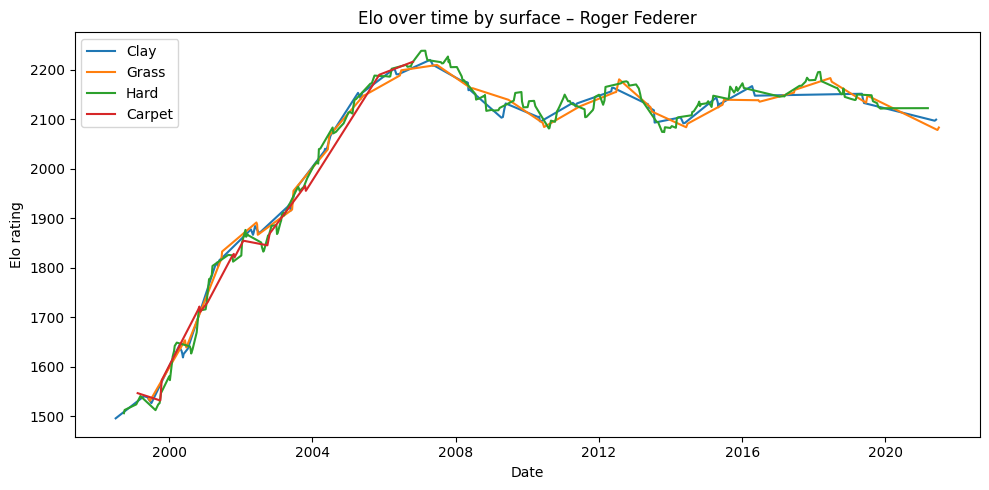

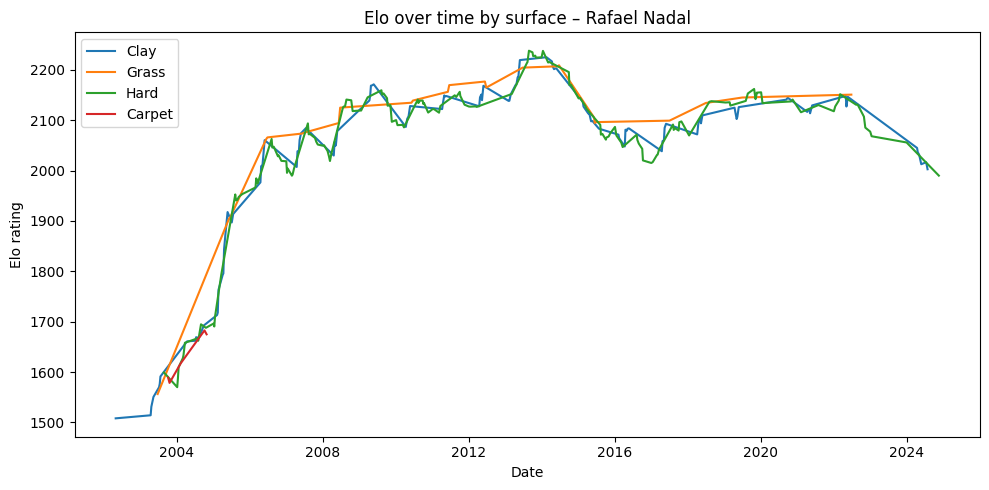

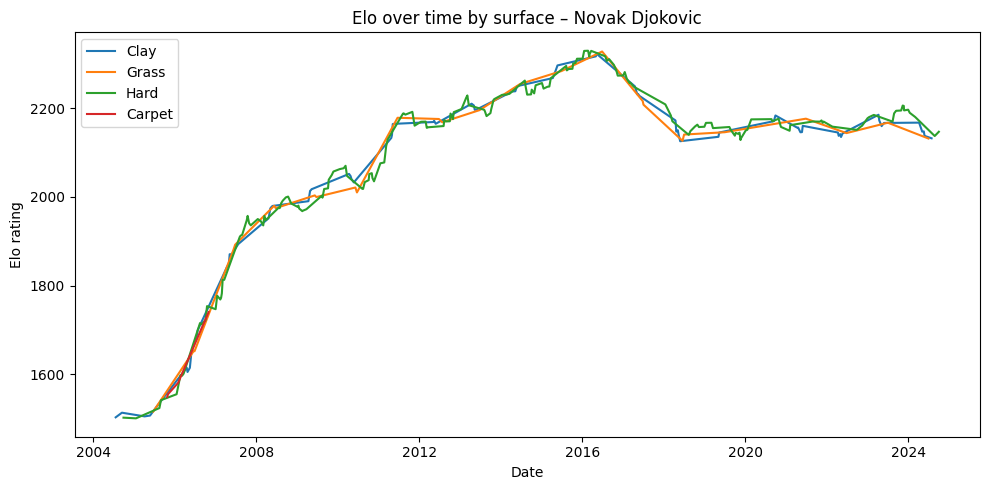

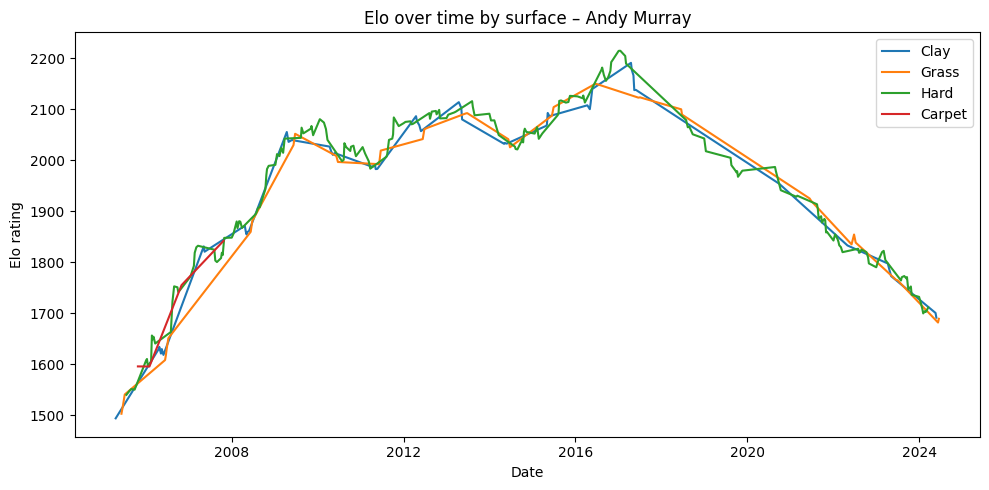

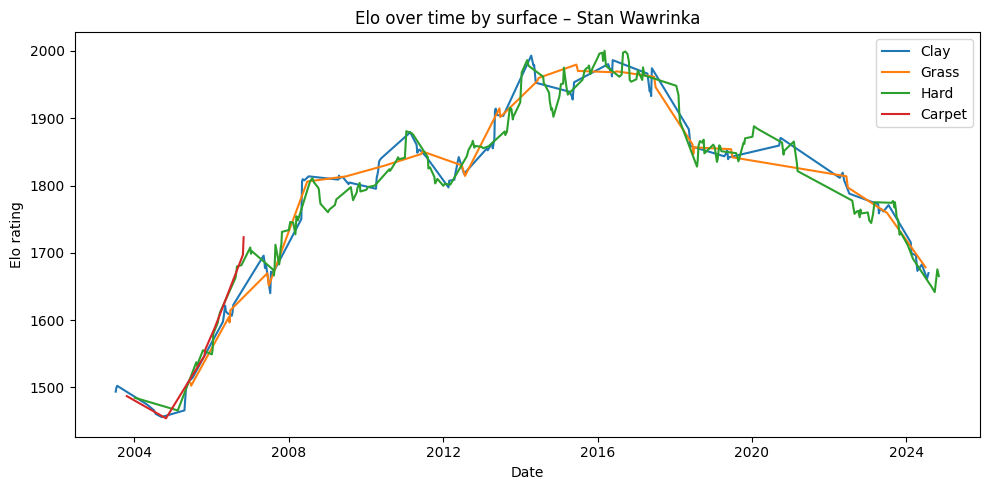

In [ ]:
import matplotlib.pyplot as plt

# Unique surfaces present for these players
unique_surfaces = merged["SURFACE"].dropna().unique()
print("Surfaces:", unique_surfaces)

for player in players:
    player_df = merged[merged["PLAYER_NAME"] == player].copy()
    if player_df.empty:
        print(f"No data for {player}, skipping.")
        continue

    plt.figure(figsize=(10, 5))

    for surface in unique_surfaces:
        s_df = player_df[player_df["SURFACE"] == surface].sort_values("MATCH_DATE")
        if s_df.empty:
            continue

        # Plot Elo over time for this surface
        plt.plot(s_df["MATCH_DATE"], s_df["ELO"], label=surface)

    plt.title(f"Elo over time by surface – {player}")
    plt.xlabel("Date")
    plt.ylabel("Elo rating")
    plt.legend()
    plt.tight_layout()
    plt.show()


### What this plot is doing

This plot shows how each players Elo rating changes over time on different surfaces.
Each color in the graph corresponds to a different surface like clay, grass, or hard court.


Surfaces found: ['Clay' 'Grass' 'Hard' 'Carpet']


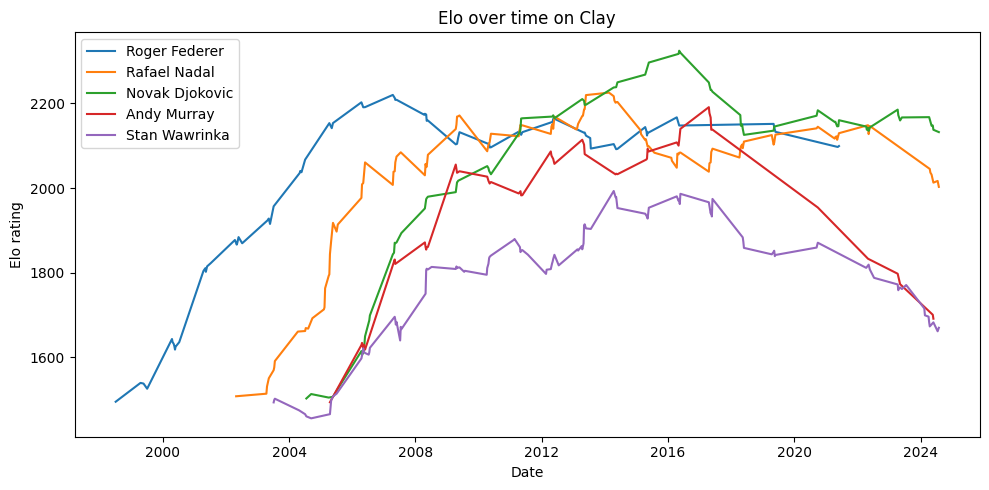

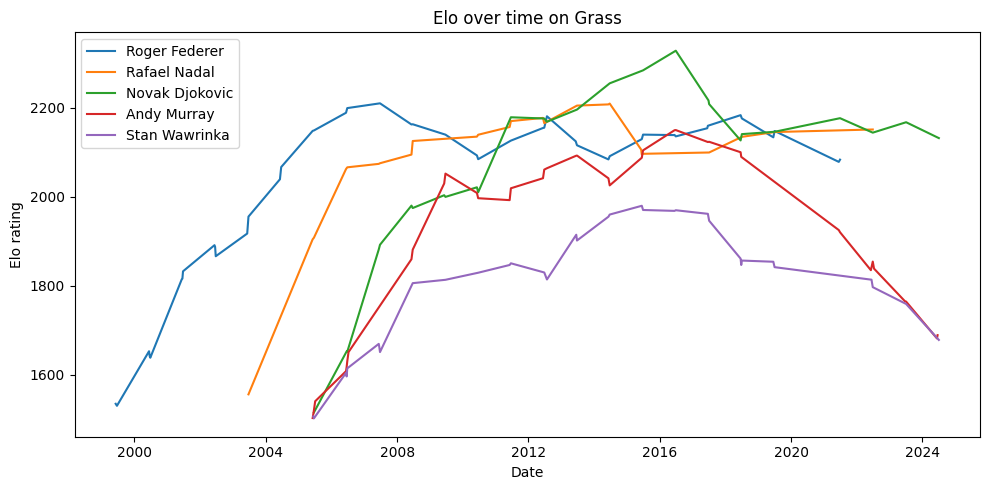

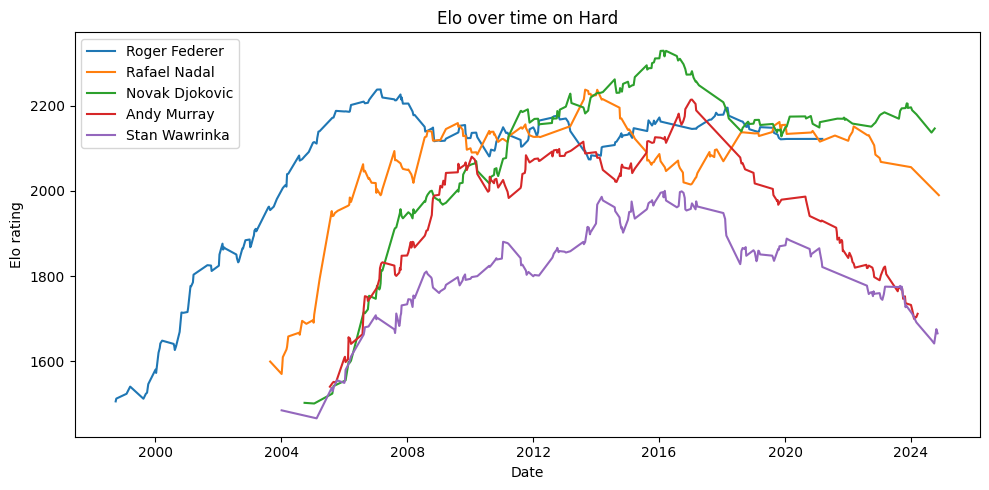

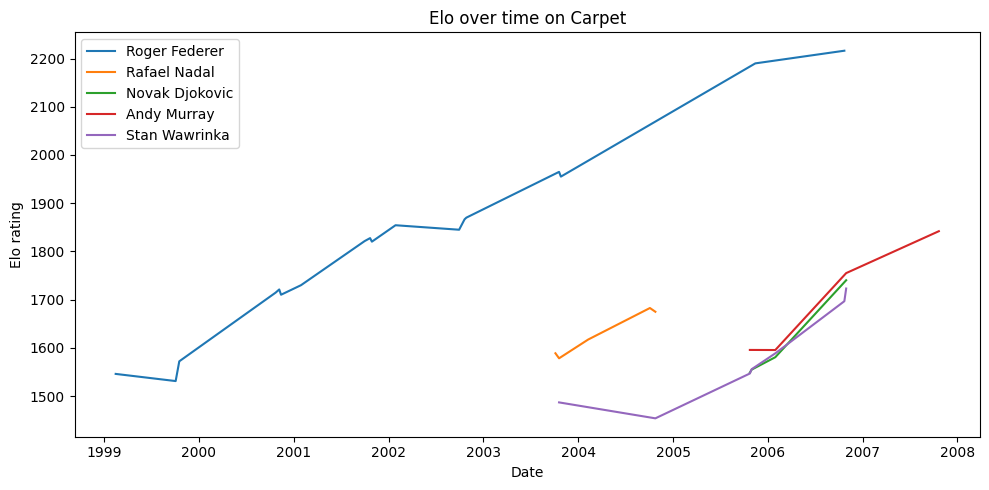

In [ ]:
import matplotlib.pyplot as plt

# STEP 6: One graph per surface, showing all 5 players

surfaces = merged["SURFACE"].dropna().unique()
print("Surfaces found:", surfaces)

for surface in surfaces:
    surf_df = merged[merged["SURFACE"] == surface].copy()
    if surf_df.empty:
        continue

    plt.figure(figsize=(10, 5))
    
    for player in players:
        p_df = surf_df[surf_df["PLAYER_NAME"] == player].sort_values("MATCH_DATE")
        if p_df.empty:
            continue
        
        # Elo over time for this player on this surface
        plt.plot(p_df["MATCH_DATE"], p_df["ELO"], label=player)

    plt.title(f"Elo over time on {surface}")
    plt.xlabel("Date")
    plt.ylabel("Elo rating")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Here's what this plot is doing

We tried to create one plot per surface (like clay, grass, hard) and shows how each of the top 5 players’ Elo ratings change over time on that surface. For each surface, it filters the data to only matches played there, then loops over the players and plots their Elo vs. match date as separate lines on the same graph. Each line is labeled with the player’s name so you can directly compare their performance on that specific surface. In the end, you get a set of graphs: one for each surface, each showing all five players’ Elo trajectories.

In [ ]:
clay_elo = pd.read_csv("Data/elo_clay_1990_2024.csv")

In [ ]:
clay_elo["date"] = pd.to_datetime(clay_elo["date"])

In [ ]:
clay_elo = clay_elo[
    (clay_elo["date"] >= "2000-01-01") &
    (clay_elo["date"] <= "2024-12-31")
]

In [ ]:
player_cols = [c for c in clay_elo.columns if c.lower() != "date"]

In [ ]:
if len(player_cols) > 5:
    last_vals = clay_elo.iloc[-1][player_cols]
    top_players = last_vals.sort_values(ascending=False).head(5).index.tolist()
else:
    top_players = player_cols

print("\nPlayers plotted:", top_players)


Players plotted: ['Rafael Nadal', 'Novak Djokovic', 'Carlos Alcaraz', 'Alexander Zverev', 'Stefanos Tsitsipas']


In [ ]:
clay_long = clay_elo.melt(
    id_vars=["date"],
    value_vars=top_players,
    var_name="PLAYER_NAME",
    value_name="ELO"
)

In [ ]:
print("Clay Elo shape (2000–2024):", clay_elo.shape)

Clay Elo shape (2000–2024): (507, 2536)


In [ ]:
# 3) Identify player columns (everything except 'date')
player_cols = [c for c in clay_elo.columns if c.lower() != "date"]

# Pick top 5 by final Elo
if len(player_cols) > 5:
    last_vals = clay_elo.iloc[-1][player_cols]
    top_players = last_vals.sort_values(ascending=False).head(5).index.tolist()
else:
    top_players = player_cols

print("Players plotted:", top_players)


Players plotted: ['Rafael Nadal', 'Novak Djokovic', 'Carlos Alcaraz', 'Alexander Zverev', 'Stefanos Tsitsipas']


In [ ]:
clay_long = clay_elo.melt(
    id_vars=["date"],
    value_vars=top_players,
    var_name="PLAYER_NAME",
    value_name="ELO"
)

base_elo = clay_long["ELO"].min()
print("Baseline Elo (approx):", base_elo)

plt.figure(figsize=(12, 6))

Baseline Elo (approx): 1466.811716220203


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

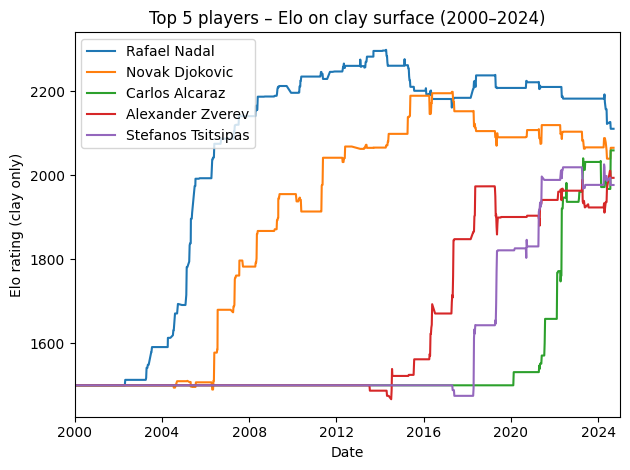

In [ ]:
for player in top_players:
    p_df = clay_long[clay_long["PLAYER_NAME"] == player].sort_values("date")

    # Trim to first non-baseline Elo
    mask = p_df["ELO"] != base_elo
    if mask.any():
        first_real = p_df.loc[mask, "date"].iloc[0]
        p_df = p_df[p_df["date"] >= first_real]

    if p_df.empty:
        continue

    plt.plot(p_df["date"], p_df["ELO"], label=player)

plt.title("Top 5 players – Elo on clay surface (2000–2024)")
plt.xlabel("Date")
plt.ylabel("Elo rating (clay only)")
plt.legend()
plt.tight_layout()
plt.xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2024-12-31"))
plt.show()

## Why this graph again and what's different???

This plot shows the clay-specific Elo trajectories of the top five players between 2000 and 2024. For each player, we first remove the flat baseline period where their Elo rating has not yet meaningfully changed (i.e., before their first non-baseline clay match), and then plot their Elo rating over time using only matches played on clay. The result is a focused comparison of how each player’s strength evolves on this single surface across the selected years.

This is different from the earlier plots, where we were using overall Elo ratings aggregated across all surfaces (hard, grass, clay, etc.). Because those ratings blended performance from every surface, the curves looked quite similar and did not highlight any clear surface-specific dominance, making it difficult to draw strong conclusions. Recognizing that Rafael Nadal is widely regarded as the “King of Clay,” we instead generated a CSV using only clay matches and recalculated Elo solely for that surface. By plotting these clay-only Elo ratings, the analysis becomes more meaningful: we can now more clearly see Nadal’s relative dominance on clay compared to other top players, as well as how each player’s clay performance evolves independently of their results on other surfaces.

Top 5 players by total wins: ['Roger Federer', 'Novak Djokovic', 'Rafael Nadal', 'Andy Murray', 'David Ferrer']


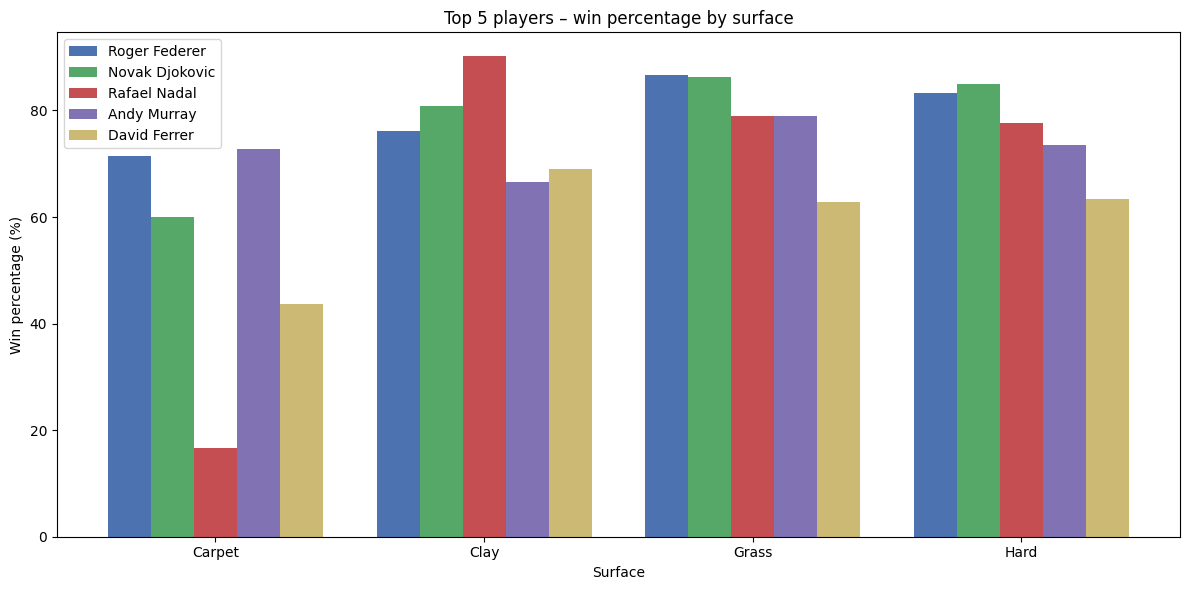

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If not already loaded:
# filtered_df = pd.read_csv("filtered_data.csv")

df = filtered_df.copy()
df["surface"] = df["surface"].astype(str).str.title()

# 1) Wins per player per surface
wins = (
    df.groupby(["winner_name", "surface"])
      .size()
      .reset_index(name="wins")
)

# 2) Total matches per player per surface (wins + losses)
as_winner = df[["winner_name", "surface"]].copy()
as_winner.columns = ["player", "surface"]

as_loser = df[["loser_name", "surface"]].copy()
as_loser.columns = ["player", "surface"]

all_matches = pd.concat([as_winner, as_loser], ignore_index=True)

matches_cnt = (
    all_matches.groupby(["player", "surface"])
               .size()
               .reset_index(name="matches")
)

# 3) Merge wins into total matches and compute win %
stats = matches_cnt.merge(
    wins,
    left_on=["player", "surface"],
    right_on=["winner_name", "surface"],
    how="left"
)

stats["wins"] = stats["wins"].fillna(0)
stats["win_pct"] = stats["wins"] / stats["matches"] * 100
stats = stats.drop(columns=["winner_name"])

# 4) Top 5 players by total wins
total_wins = (
    stats.groupby("player")["wins"]
         .sum()
         .sort_values(ascending=False)
)

top5_players = total_wins.head(5).index.tolist()
print("Top 5 players by total wins:", top5_players)

stats_top5 = stats[stats["player"].isin(top5_players)].copy()

# 5) Pivot to surface x player → win_pct
surfaces = sorted(stats_top5["surface"].unique())
pivot = (
    stats_top5.pivot(index="surface", columns="player", values="win_pct")
              .reindex(surfaces)
              .reindex(columns=top5_players)
              .fillna(0)
)

# 6) Grouped bar plot: one graph, softer complementary colors per player
n_surfaces = len(surfaces)
n_players = len(top5_players)

x = np.arange(n_surfaces)
bar_width = 0.8 / n_players

# Softer, complementary-ish colors (one per player)
colors = [
    "#4c72b0",  # muted blue
    "#55a868",  # soft green
    "#c44e52",  # muted red
    "#8172b3",  # soft purple
    "#ccb974",  # warm ochre
]

plt.figure(figsize=(12, 6))

for i, player in enumerate(top5_players):
    y = pivot[player].values
    plt.bar(
        x + i * bar_width,
        y,
        width=bar_width,
        label=player,
        color=colors[i % len(colors)],
    )

plt.xticks(x + bar_width * (n_players - 1) / 2, surfaces)
plt.xlabel("Surface")
plt.ylabel("Win percentage (%)")
plt.title("Top 5 players – win percentage by surface")
plt.legend()
plt.tight_layout()
plt.show()


Top 5 players: ['Roger Federer', 'Novak Djokovic', 'Rafael Nadal', 'Andy Murray', 'David Ferrer']


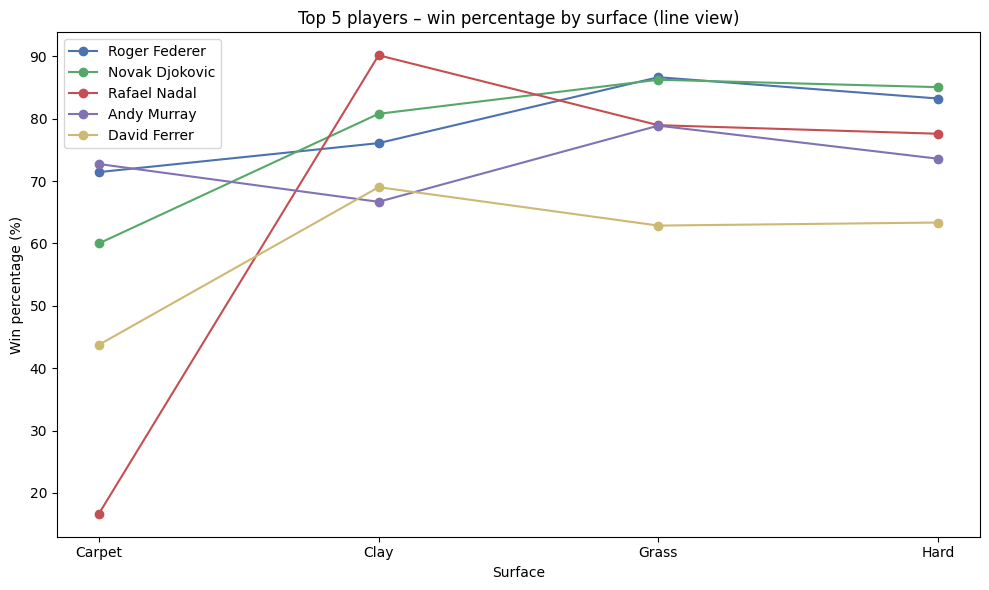

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If not already loaded:
# filtered_df = pd.read_csv("filtered_data.csv")

df = filtered_df.copy()
df["surface"] = df["surface"].astype(str).str.title()

# 1) Wins per player per surface
wins = (
    df.groupby(["winner_name", "surface"])
      .size()
      .reset_index(name="wins")
)

# 2) Total matches per player per surface (wins + losses)
as_winner = df[["winner_name", "surface"]].copy()
as_winner.columns = ["player", "surface"]

as_loser = df[["loser_name", "surface"]].copy()
as_loser.columns = ["player", "surface"]

all_matches = pd.concat([as_winner, as_loser], ignore_index=True)

matches_cnt = (
    all_matches.groupby(["player", "surface"])
               .size()
               .reset_index(name="matches")
)

# 3) Merge wins into total matches and compute win %
stats = matches_cnt.merge(
    wins,
    left_on=["player", "surface"],
    right_on=["winner_name", "surface"],
    how="left"
)

stats["wins"] = stats["wins"].fillna(0)
stats["win_pct"] = stats["wins"] / stats["matches"] * 100
stats = stats.drop(columns=["winner_name"])

# 4) Top 5 players by total wins
total_wins = (
    stats.groupby("player")["wins"]
         .sum()
         .sort_values(ascending=False)
)

top5_players = total_wins.head(5).index.tolist()
print("Top 5 players:", top5_players)

stats_top5 = stats[stats["player"].isin(top5_players)].copy()

# 5) Prepare data for line plot (surfaces on x, win% on y)
surfaces = sorted(stats_top5["surface"].unique())
x = np.arange(len(surfaces))

# Pivot: surface x player -> win_pct
pivot = (
    stats_top5.pivot(index="surface", columns="player", values="win_pct")
              .reindex(surfaces)
    .reindex(columns=top5_players)
    .fillna(0)
)

# 6) Line plot: one line per player, points on each surface
plt.figure(figsize=(10, 6))

colors = [
    "#4c72b0",  # muted blue
    "#55a868",  # soft green
    "#c44e52",  # muted red
    "#8172b3",  # soft purple
    "#ccb974",  # warm ochre
]

for i, player in enumerate(top5_players):
    y = pivot[player].values
    plt.plot(
        x,
        y,
        marker="o",
        label=player,
        color=colors[i % len(colors)],
    )

plt.xticks(x, surfaces)
plt.xlabel("Surface")
plt.ylabel("Win percentage (%)")
plt.title("Top 5 players – win percentage by surface (line view)")
plt.legend()
plt.tight_layout()
plt.show()


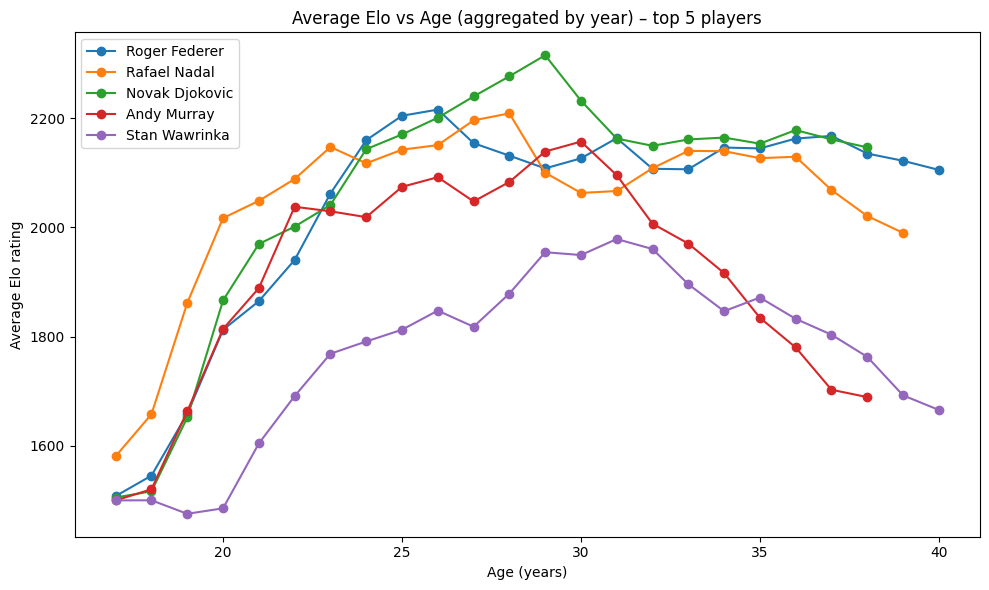

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Aggregate Elo by integer age for each player
age_elo_int = age_elo.copy()
age_elo_int["age_int"] = age_elo_int["age_years"].round().astype(int)

avg_age_elo = (
    age_elo_int
    .groupby(["PLAYER_NAME", "age_int"])["ELO"]
    .mean()
    .reset_index()
)

# Optional: keep a reasonable age range
avg_age_elo = avg_age_elo[
    (avg_age_elo["age_int"] >= 17) & (avg_age_elo["age_int"] <= 40)
]

# 2) Single graph: age on x, average Elo on y, one line per player
plt.figure(figsize=(10, 6))

for player in players:
    p_df = avg_age_elo[avg_age_elo["PLAYER_NAME"] == player].sort_values("age_int")
    if p_df.empty:
        continue
    plt.plot(p_df["age_int"], p_df["ELO"], marker="o", label=player)

plt.xlabel("Age (years)")
plt.ylabel("Average Elo rating")
plt.title("Average Elo vs Age (aggregated by year) – top 5 players")
plt.legend()
plt.tight_layout()
plt.show()


## This graph shows
how the average Elo rating of each of the five players evolves as they age, with Elo values aggregated at each integer year from about 17 to 40. By smoothing Elo into age buckets, it highlights the typical performance level at a given age instead of match-by-match noise. You can clearly see at what ages each player reaches their peak average Elo, how long they sustain that peak, and how sharply their performance rises or declines compared to the others. Overall, it gives a clean comparison of career “shape” and longevity across the top players.

In [ ]:
import pandas as pd
all_data = pd.read_csv("Data/elo_from_federer_start.csv")

In [ ]:
all_data.head()

,date,Andreas Vinciguerra,Roger Federer,James Blake,Steven Randjelovic,Jing Zhu Yang,Febi Widhiyanto,Mike Scheidweiler,Bryan Juinio,Seyed Akbar Taheri Rahaghi,...,Philip Hjorth,Demetris Azoides,Siddharth Vishwakarma,Yousaf Khalil,Iliyan Radulov,Jack Loutit,Justin Engel,Theo Papamalamis,Branko Djuric,Nishesh Basavareddy
0,1900-01-01,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
1,1967-12-28,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2,1968-01-01,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
3,1968-01-02,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
4,1968-01-08,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


/var/folders/kr/yz8jz8nj2g9bjldwdvm8d1yw0000gn/T/ipykernel_76348/1435935424.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(unique_players))


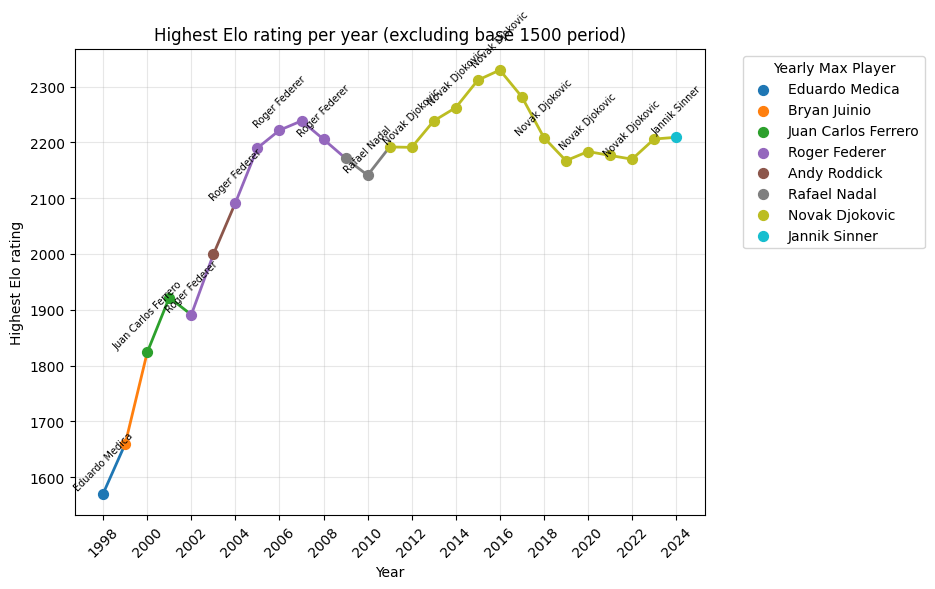

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ==========================================================
# 1. DATA PREPARATION (REQUIRED to define yearly_max_filtered)
#    This block replaces the implicit dependency.
# ==========================================================
# NOTE: You MUST load or define your original 'all_data' DataFrame here. 
#       The following is conceptual and needs your actual data.

# Placeholder for the user's data loading, which is necessary:
# try:
#     all_data = pd.read_csv('your_elo_data.csv')
# except FileNotFoundError:
#     print("ERROR: Please load your 'all_data' DataFrame here.")
#     # return 

# --- If we assume 'all_data' is loaded, here is the processing logic: ---
# make sure date is datetime
all_data['date'] = pd.to_datetime(all_data['date'])

# player columns = everything except 'date'
player_cols = all_data.columns.drop('date')

# row-wise max elo + player
all_data['max_elo'] = all_data[player_cols].max(axis=1)
all_data['player']  = all_data[player_cols].idxmax(axis=1)

# year column
all_data['year'] = all_data['date'].dt.year

# for each year, pick the row with highest Elo
idx = all_data.groupby('year')['max_elo'].idxmax()
yearly_max = (
    all_data.loc[idx, ['year', 'player', 'max_elo']]
    .sort_values('year')
    .reset_index(drop=True)
)

# Drop base-Elo years (1500) - This is where yearly_max_filtered is created
base_elo = 1500.0
yearly_max_filtered = yearly_max[yearly_max['max_elo'] > base_elo].copy()

# ==========================================================
# 2. PLOTTING LOGIC (Your code block)
# ==========================================================
plt.figure(figsize=(12, 6))

# Prepare data for plotting
unique_players = yearly_max_filtered['player'].unique()
colors = cm.get_cmap('tab10', len(unique_players))
player_color_map = {player: colors(i) for i, player in enumerate(unique_players)}

# Loop to plot points and line segments with different colors
for i in range(len(yearly_max_filtered)):
    row_current = yearly_max_filtered.iloc[i]
    player = row_current['player']
    color = player_color_map[player]
    
    # Logic to ensure the player name is added to the legend only once
    label = player if player not in plt.gca().get_legend_handles_labels()[1] else "_nolegend_"

    # Plot the current year's peak point (scatter plot)
    plt.scatter(row_current['year'], row_current['max_elo'],
                color=color, marker='o', s=50, label=label, zorder=3)

    # Plot the line segment connecting to the next year's point
    if i < len(yearly_max_filtered) - 1:
        row_next = yearly_max_filtered.iloc[i+1]
        plt.plot([row_current['year'], row_next['year']],
                 [row_current['max_elo'], row_next['max_elo']],
                 color=color, linestyle='-', linewidth=2, zorder=2)

# Prepare for annotation and ticks
ymf_reset = yearly_max_filtered.reset_index(drop=True)

# Annotate every 2nd point with the player's name
for i, row in ymf_reset.iterrows():
    if i % 2 == 0:
        plt.text(row['year'], row['max_elo'] + 5,
                 row['player'], ha='center', fontsize=7, rotation=45)

# Final plot formatting
plt.xlabel('Year')
plt.ylabel('Highest Elo rating')
plt.title('Highest Elo rating per year (excluding base 1500 period)')
plt.grid(True, alpha=0.3)
plt.xticks(ymf_reset['year'][::2], rotation=45) # Show every 2nd year on the axis

# Add legend and adjust layout
plt.legend(title='Yearly Max Player', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

In [ ]:
# Cell 2: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# plotting defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10


## Elo Rating Plot Description

In this section, I plot the Elo rating trajectories of the top 40 tennis players in the dataset, with Rafael Nadal, Roger Federer, Novak Djokovic, and Andy Murray highlighted. Before plotting, I clean the data so that each player's curve begins at their actual career start (the first non-default Elo value), ensuring the visualization reflects real career timelines rather than long initialization lines. The final chart compares the Big Four’s Elo progression against the broader top-40 field.


Saved fixed plot to Data/elo_latest400_top4_highlight_fixed.png


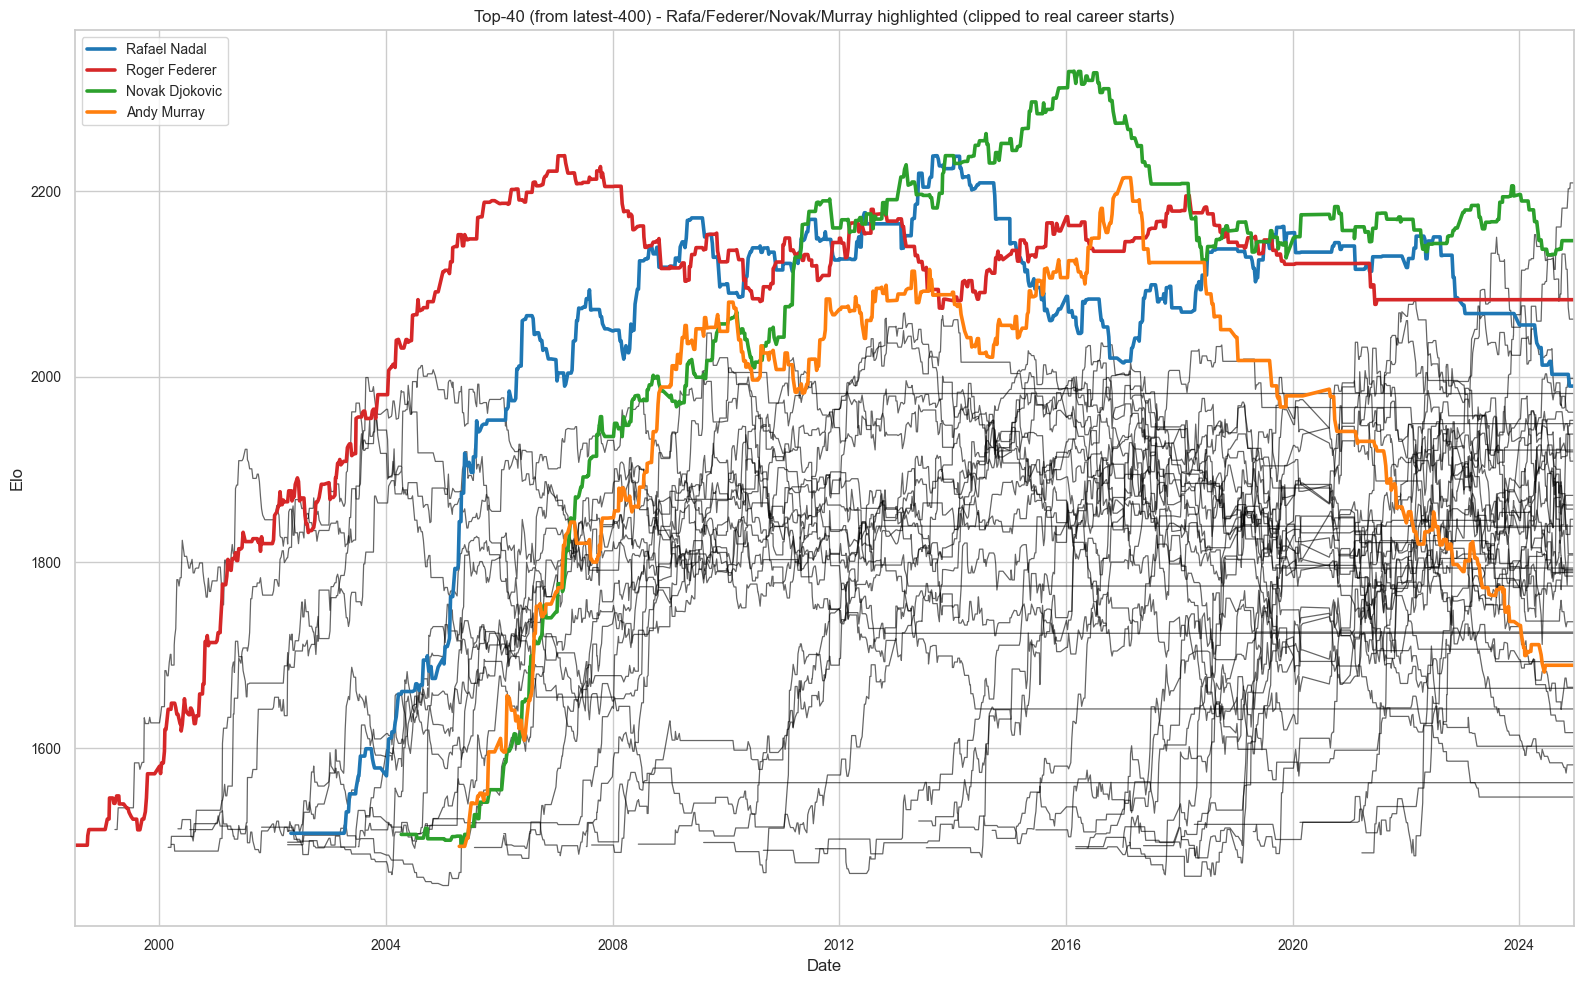

In [ ]:
# Fixed plot: highlight Rafa/Federer/Novak/Murray and clip each series to player's real start (no 1900 rows)
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "Data/elo_from_federer_start.csv"
df = pd.read_csv(csv_path, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
players = [c for c in df.columns if c != "date"]

# choose top-40 by peak Elo inside this CSV
peak_vals = {p: df[p].max(skipna=True) for p in players}
sorted_players = sorted(peak_vals.items(), key=lambda x: x[1], reverse=True)
selected_top40 = [p for p,_ in sorted_players[:40]]

# Ensure highlighted players are present and included
highlight = ["Rafael Nadal", "Roger Federer", "Novak Djokovic", "Andy Murray"]
for h in highlight:
    if h in players and h not in selected_top40:
        selected_top40.insert(0, h)  # ensure they appear and are plotted

# helper to find player's first real date (value != 1500 and not null)
def player_start_date(series: pd.Series) -> pd.Timestamp | None:
    mask = series.notna() & (series != 1500)
    if not mask.any():
        return None
    return series.index[mask.argmax()] if False else series.index[mask.values.argmax()]

# Better: use df to find date of first non-1500
start_dates = {}
for p in selected_top40:
    ser = df[p]
    mask = ser.notna() & (ser != 1500)
    if mask.any():
        start_dates[p] = df.loc[mask, 'date'].iloc[0]
    else:
        # if never departs from 1500, set to None
        start_dates[p] = None

# Determine overall plot x-limits: earliest of highlighted starts (if available)
highlight_starts = [d for p,d in start_dates.items() if p in highlight and d is not None]
if highlight_starts:
    x_min = min(highlight_starts)
else:
    x_min = df['date'].min()

# Plot
plt.figure(figsize=(16,10))
# plot non-highlighted selected players in black, but clipped to their start
for p in selected_top40:
    if p in highlight:
        continue
    sdate = start_dates.get(p)
    if sdate is None:
        continue
    mask = df['date'] >= sdate
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], color='black', alpha=0.6, linewidth=0.9)

# plot highlighted players with colors, clipped to their start
color_map = {"Rafael Nadal": "tab:blue", "Roger Federer": "tab:red", "Novak Djokovic": "tab:green", "Andy Murray": "tab:orange"}
for p in highlight:
    if p not in players:
        print(f"Warning: {p} not in data; skipping")
        continue
    sdate = start_dates.get(p)
    if sdate is None:
        # plot from earliest available date if no start detected
        mask = df['date'] >= x_min
    else:
        mask = df['date'] >= sdate
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], label=p, color=color_map.get(p, None), linewidth=2.6)

plt.legend(loc='upper left', fontsize=10)
plt.title('Top-40 (from latest-400) - Rafa/Federer/Novak/Murray highlighted (clipped to real career starts)')
plt.xlabel('Date')
plt.ylabel('Elo')
plt.xlim(x_min, df['date'].max())
plt.tight_layout()
out_png = 'Data/elo_latest400_top4_highlight_fixed.png'
plt.savefig(out_png, dpi=200)
print(f"Saved fixed plot to {out_png}")
plt.show()
